In [1]:
import torch
import torchvision
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_set = torchvision.datasets.FashionMNIST(
    root='data', transform=torchvision.transforms.ToTensor(), train=True, download=True
)


Using downloaded and verified file: data/FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw

Using downloaded and verified file: data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [5]:
class Generator(torch.nn.Module):
    def __init__(self, indim, outdim=28*28):
        super(Generator, self).__init__()
        
        self.gen = torch.nn.Sequential(
            self.unit(indim, 128, batch_norm=True),
            self.unit(128, 256, batch_norm=True),
            self.unit(256, 512, batch_norm=True),
            self.unit(512, 1024, batch_norm=True),
            self.unit(1024, 2048, batch_norm=True),
            torch.nn.Linear(2048, outdim),
            torch.nn.Sigmoid()
        )
    
    def unit(self, indim, outdim, batch_norm=False):
        if batch_norm:
            return torch.nn.Sequential(
                torch.nn.Linear(indim, outdim),
                torch.nn.BatchNorm1d(outdim),
                torch.nn.ReLU(inplace=True)
            )
        else:
            return torch.nn.Sequential(
                torch.nn.Linear(indim, outdim),
                torch.nn.ReLU(inplace=True)
            )
        
    def forward(self, noise):
        return self.gen(noise)
    

class Discriminator(torch.nn.Module):
    def __init__(self, indim=28*28):
        super(Discriminator, self).__init__()
        
        self.disc = torch.nn.Sequential(
            self.unit(indim, 512, batch_norm=False),
            self.unit(512, 256, batch_norm=False),
            self.unit(256, 128, batch_norm=False),
            self.unit(128, 64, batch_norm=False),
            torch.nn.Linear(64, 1),
        )
        
    def unit(self, indim, outdim, batch_norm=False):
        if batch_norm:
            return torch.nn.Sequential(
                torch.nn.Linear(indim, outdim),
                torch.nn.BatchNorm1d(outdim),
                torch.nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return torch.nn.Sequential(
                torch.nn.Linear(indim, outdim),
                torch.nn.Dropout(0.5),
                torch.nn.LeakyReLU(0.2, inplace=True)
            )
        
    def forward(self, image):
        return self.disc(image)

In [6]:
def disc_loss_fn(disc_model, real, fake, criterion):
    # Real Image
    real_preds = disc_model(real)
    real_loss = criterion(real_preds, torch.ones_like(real_preds))
    
    # Fake Image
    fake_preds = disc_model(fake.detach())
    fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
    
    return real_loss + fake_loss

def gen_loss_fn(gen_model, disc_model, noise, criterion):
    fake = gen_model(noise)
    fake_preds = disc_model(fake)
    fake_loss = criterion(fake_preds, torch.ones_like(fake_preds))
    
    return fake_loss, fake

def random_noise(batch_size, dim=10, device='cuda'):
    return torch.randn(batch_size, dim, device=device)

In [7]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

Epoch:   10/2000 | G Loss: 0.79945 | D Loss: 1.2384
Epoch:   20/2000 | G Loss: 0.85762 | D Loss: 1.2562
Epoch:   30/2000 | G Loss: 0.84239 | D Loss: 1.2648
Epoch:   40/2000 | G Loss: 0.79165 | D Loss: 1.2953
Epoch:   50/2000 | G Loss: 0.78912 | D Loss: 1.3415
Epoch:   60/2000 | G Loss: 0.71945 | D Loss: 1.3856
Epoch:   70/2000 | G Loss: 0.73951 | D Loss: 1.3916
Epoch:   80/2000 | G Loss: 0.69451 | D Loss: 1.3927
Epoch:   90/2000 | G Loss: 0.68142 | D Loss: 1.3718


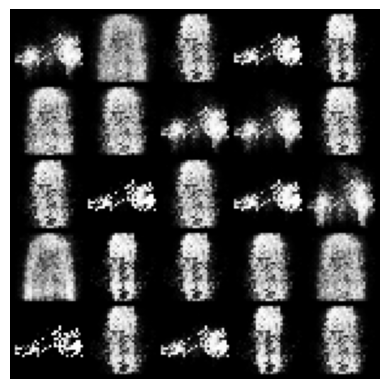

Epoch:  100/2000 | G Loss: 0.72085 | D Loss: 1.3787
Epoch:  110/2000 | G Loss: 0.71338 | D Loss: 1.3665
Epoch:  120/2000 | G Loss: 0.70186 | D Loss: 1.3754
Epoch:  130/2000 | G Loss: 0.71062 | D Loss: 1.3739
Epoch:  140/2000 | G Loss: 0.68543 | D Loss: 1.3884
Epoch:  150/2000 | G Loss: 0.7022 | D Loss: 1.3787
Epoch:  160/2000 | G Loss: 0.68951 | D Loss: 1.3846
Epoch:  170/2000 | G Loss: 0.7602 | D Loss: 1.3809
Epoch:  180/2000 | G Loss: 0.69758 | D Loss: 1.3509
Epoch:  190/2000 | G Loss: 0.71095 | D Loss: 1.3835


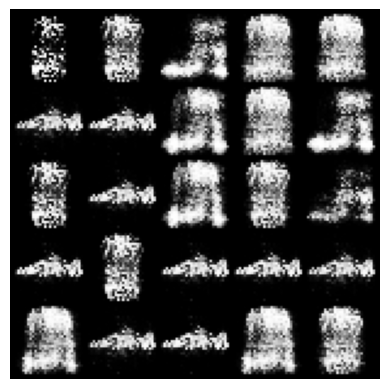

Epoch:  200/2000 | G Loss: 0.69608 | D Loss: 1.3748
Epoch:  210/2000 | G Loss: 0.71385 | D Loss: 1.366
Epoch:  220/2000 | G Loss: 0.69851 | D Loss: 1.3779
Epoch:  230/2000 | G Loss: 0.6804 | D Loss: 1.3771
Epoch:  240/2000 | G Loss: 0.70255 | D Loss: 1.3671
Epoch:  250/2000 | G Loss: 0.7154 | D Loss: 1.3828
Epoch:  260/2000 | G Loss: 0.70388 | D Loss: 1.4006
Epoch:  270/2000 | G Loss: 0.70211 | D Loss: 1.3664
Epoch:  280/2000 | G Loss: 0.67746 | D Loss: 1.3618
Epoch:  290/2000 | G Loss: 0.70282 | D Loss: 1.3772


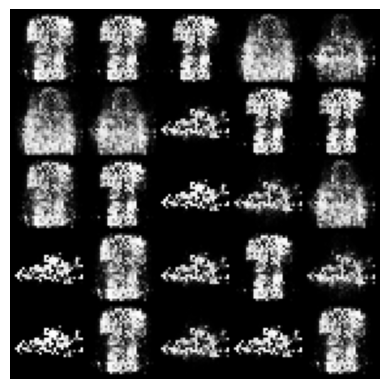

Epoch:  300/2000 | G Loss: 0.71139 | D Loss: 1.3929
Epoch:  310/2000 | G Loss: 0.70489 | D Loss: 1.3894
Epoch:  320/2000 | G Loss: 0.7094 | D Loss: 1.3665
Epoch:  330/2000 | G Loss: 0.70539 | D Loss: 1.3879
Epoch:  340/2000 | G Loss: 0.684 | D Loss: 1.3829
Epoch:  350/2000 | G Loss: 0.68885 | D Loss: 1.3791
Epoch:  360/2000 | G Loss: 0.6848 | D Loss: 1.3871
Epoch:  370/2000 | G Loss: 0.70671 | D Loss: 1.3724
Epoch:  380/2000 | G Loss: 0.72122 | D Loss: 1.3855
Epoch:  390/2000 | G Loss: 0.69954 | D Loss: 1.3833
Epoch:  470/2000 | G Loss: 0.67611 | D Loss: 1.3805
Epoch:  480/2000 | G Loss: 0.68449 | D Loss: 1.3842
Epoch:  490/2000 | G Loss: 0.68183 | D Loss: 1.3832


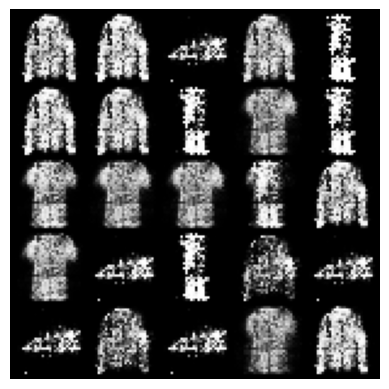

Epoch:  500/2000 | G Loss: 0.70832 | D Loss: 1.3437
Epoch:  510/2000 | G Loss: 0.68993 | D Loss: 1.378
Epoch:  520/2000 | G Loss: 0.70036 | D Loss: 1.3801
Epoch:  530/2000 | G Loss: 0.694 | D Loss: 1.3856
Epoch:  540/2000 | G Loss: 0.76899 | D Loss: 1.3764
Epoch:  550/2000 | G Loss: 0.66575 | D Loss: 1.3863
Epoch:  560/2000 | G Loss: 0.69655 | D Loss: 1.373
Epoch:  570/2000 | G Loss: 0.70775 | D Loss: 1.382
Epoch:  580/2000 | G Loss: 0.7116 | D Loss: 1.3815
Epoch:  590/2000 | G Loss: 0.71565 | D Loss: 1.387


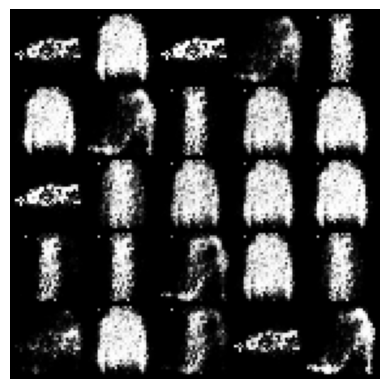

Epoch:  600/2000 | G Loss: 0.6848 | D Loss: 1.3849
Epoch:  610/2000 | G Loss: 0.69961 | D Loss: 1.388
Epoch:  620/2000 | G Loss: 0.70994 | D Loss: 1.3832
Epoch:  630/2000 | G Loss: 0.68373 | D Loss: 1.3865
Epoch:  640/2000 | G Loss: 0.70705 | D Loss: 1.3868
Epoch:  650/2000 | G Loss: 0.69017 | D Loss: 1.3958
Epoch:  660/2000 | G Loss: 0.68307 | D Loss: 1.3816
Epoch:  670/2000 | G Loss: 0.68781 | D Loss: 1.3874
Epoch:  680/2000 | G Loss: 0.69153 | D Loss: 1.3865
Epoch:  690/2000 | G Loss: 0.69693 | D Loss: 1.387


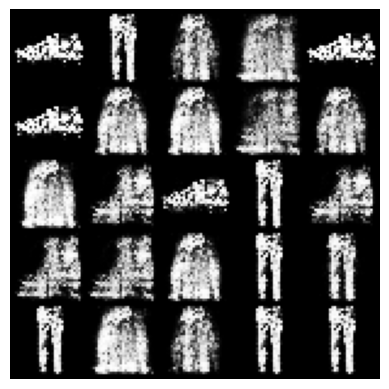

Epoch:  700/2000 | G Loss: 0.68114 | D Loss: 1.3876
Epoch:  710/2000 | G Loss: 0.71814 | D Loss: 1.3854
Epoch:  720/2000 | G Loss: 0.6871 | D Loss: 1.3808
Epoch:  730/2000 | G Loss: 0.69609 | D Loss: 1.382
Epoch:  740/2000 | G Loss: 0.71997 | D Loss: 1.3756
Epoch:  750/2000 | G Loss: 0.69761 | D Loss: 1.3818
Epoch:  760/2000 | G Loss: 0.69715 | D Loss: 1.3881
Epoch:  770/2000 | G Loss: 0.6989 | D Loss: 1.3915
Epoch:  780/2000 | G Loss: 0.67597 | D Loss: 1.3858
Epoch:  790/2000 | G Loss: 0.68848 | D Loss: 1.384
Epoch:  860/2000 | G Loss: 0.69524 | D Loss: 1.3842
Epoch:  870/2000 | G Loss: 0.6894 | D Loss: 1.3837
Epoch:  880/2000 | G Loss: 0.68836 | D Loss: 1.3856
Epoch:  890/2000 | G Loss: 0.68427 | D Loss: 1.388


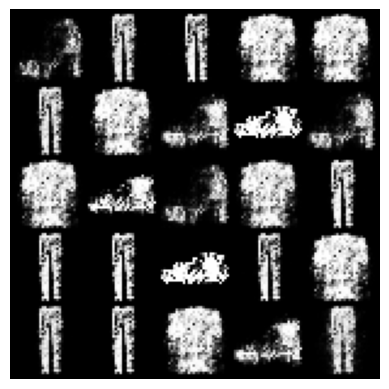

Epoch:  900/2000 | G Loss: 0.68991 | D Loss: 1.388
Epoch:  910/2000 | G Loss: 0.68453 | D Loss: 1.3912
Epoch:  920/2000 | G Loss: 0.69075 | D Loss: 1.381
Epoch:  930/2000 | G Loss: 0.70199 | D Loss: 1.3885
Epoch:  940/2000 | G Loss: 0.67994 | D Loss: 1.3881
Epoch:  950/2000 | G Loss: 0.70432 | D Loss: 1.3867
Epoch:  960/2000 | G Loss: 0.68714 | D Loss: 1.3919
Epoch:  970/2000 | G Loss: 0.69703 | D Loss: 1.3855
Epoch:  980/2000 | G Loss: 0.68854 | D Loss: 1.3851
Epoch:  990/2000 | G Loss: 0.68712 | D Loss: 1.3858
Epoch: 1060/2000 | G Loss: 0.70159 | D Loss: 1.3877
Epoch: 1070/2000 | G Loss: 0.69652 | D Loss: 1.3869
Epoch: 1080/2000 | G Loss: 0.69438 | D Loss: 1.3867
Epoch: 1090/2000 | G Loss: 0.70154 | D Loss: 1.3803


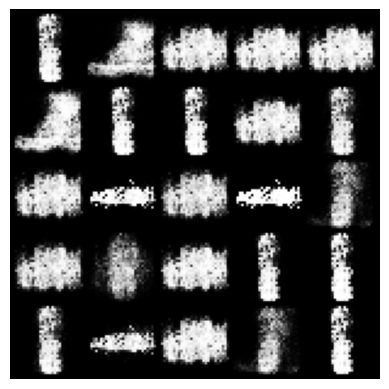

Epoch: 1100/2000 | G Loss: 0.68251 | D Loss: 1.3876
Epoch: 1110/2000 | G Loss: 0.6907 | D Loss: 1.385
Epoch: 1120/2000 | G Loss: 0.69426 | D Loss: 1.3876
Epoch: 1130/2000 | G Loss: 0.69991 | D Loss: 1.3878
Epoch: 1140/2000 | G Loss: 0.6924 | D Loss: 1.3825
Epoch: 1150/2000 | G Loss: 0.70555 | D Loss: 1.3867
Epoch: 1160/2000 | G Loss: 0.69319 | D Loss: 1.3879
Epoch: 1170/2000 | G Loss: 0.6972 | D Loss: 1.3894
Epoch: 1180/2000 | G Loss: 0.6922 | D Loss: 1.3817
Epoch: 1190/2000 | G Loss: 0.69541 | D Loss: 1.3879


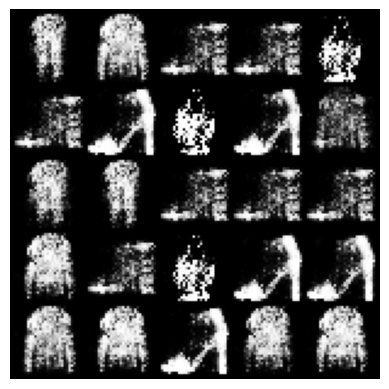

Epoch: 1200/2000 | G Loss: 0.70129 | D Loss: 1.3813
Epoch: 1210/2000 | G Loss: 0.68505 | D Loss: 1.3878
Epoch: 1220/2000 | G Loss: 0.69039 | D Loss: 1.3847
Epoch: 1230/2000 | G Loss: 0.69422 | D Loss: 1.3885
Epoch: 1240/2000 | G Loss: 0.69387 | D Loss: 1.3809
Epoch: 1260/2000 | G Loss: 0.69288 | D Loss: 1.3867
Epoch: 1270/2000 | G Loss: 0.69293 | D Loss: 1.3851
Epoch: 1280/2000 | G Loss: 0.69191 | D Loss: 1.3848
Epoch: 1290/2000 | G Loss: 0.70248 | D Loss: 1.3858
Epoch: 1370/2000 | G Loss: 0.69152 | D Loss: 1.3881
Epoch: 1380/2000 | G Loss: 0.68852 | D Loss: 1.3837
Epoch: 1390/2000 | G Loss: 0.6956 | D Loss: 1.3875


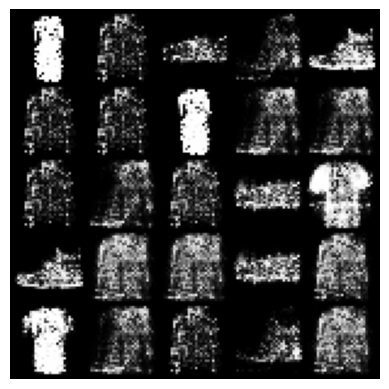

Epoch: 1400/2000 | G Loss: 0.69032 | D Loss: 1.3847
Epoch: 1410/2000 | G Loss: 0.69337 | D Loss: 1.3879
Epoch: 1420/2000 | G Loss: 0.69384 | D Loss: 1.3859
Epoch: 1430/2000 | G Loss: 0.69129 | D Loss: 1.3866
Epoch: 1440/2000 | G Loss: 0.69473 | D Loss: 1.3857
Epoch: 1450/2000 | G Loss: 0.70308 | D Loss: 1.3828
Epoch: 1460/2000 | G Loss: 0.6906 | D Loss: 1.3875
Epoch: 1470/2000 | G Loss: 0.68956 | D Loss: 1.3859
Epoch: 1480/2000 | G Loss: 0.70527 | D Loss: 1.3875
Epoch: 1490/2000 | G Loss: 0.69284 | D Loss: 1.3863


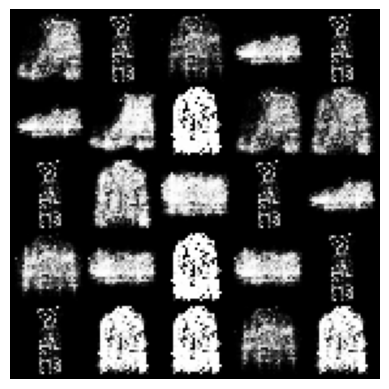

Epoch: 1500/2000 | G Loss: 0.6899 | D Loss: 1.3854
Epoch: 1510/2000 | G Loss: 0.68742 | D Loss: 1.3877
Epoch: 1520/2000 | G Loss: 0.69331 | D Loss: 1.387
Epoch: 1530/2000 | G Loss: 0.6952 | D Loss: 1.3852
Epoch: 1540/2000 | G Loss: 0.69203 | D Loss: 1.3865
Epoch: 1550/2000 | G Loss: 0.68876 | D Loss: 1.3864
Epoch: 1560/2000 | G Loss: 0.69603 | D Loss: 1.3867
Epoch: 1570/2000 | G Loss: 0.69865 | D Loss: 1.3866
Epoch: 1580/2000 | G Loss: 0.68575 | D Loss: 1.3852
Epoch: 1590/2000 | G Loss: 0.69923 | D Loss: 1.38
Epoch: 1640/2000 | G Loss: 0.69758 | D Loss: 1.3851
Epoch: 1650/2000 | G Loss: 0.72513 | D Loss: 1.391
Epoch: 1660/2000 | G Loss: 0.67817 | D Loss: 1.3939
Epoch: 1670/2000 | G Loss: 0.71047 | D Loss: 1.3838
Epoch: 1680/2000 | G Loss: 0.66827 | D Loss: 1.3871
Epoch: 1690/2000 | G Loss: 0.67742 | D Loss: 1.391


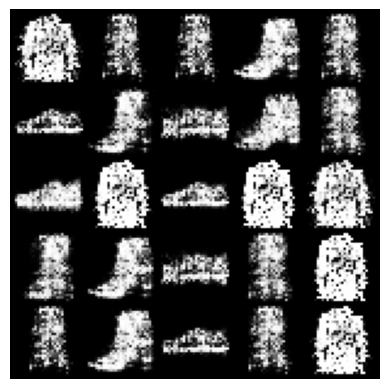

Epoch: 1700/2000 | G Loss: 0.68743 | D Loss: 1.3733
Epoch: 1710/2000 | G Loss: 0.69694 | D Loss: 1.3873
Epoch: 1720/2000 | G Loss: 0.6922 | D Loss: 1.3865
Epoch: 1730/2000 | G Loss: 0.69494 | D Loss: 1.3849
Epoch: 1740/2000 | G Loss: 0.69013 | D Loss: 1.3885
Epoch: 1750/2000 | G Loss: 0.68883 | D Loss: 1.3865
Epoch: 1760/2000 | G Loss: 0.702 | D Loss: 1.3778
Epoch: 1770/2000 | G Loss: 0.69288 | D Loss: 1.3823
Epoch: 1780/2000 | G Loss: 0.67829 | D Loss: 1.3928
Epoch: 1790/2000 | G Loss: 0.69974 | D Loss: 1.3881
Epoch: 1860/2000 | G Loss: 0.69435 | D Loss: 1.3858
Epoch: 1870/2000 | G Loss: 0.68783 | D Loss: 1.3874
Epoch: 1880/2000 | G Loss: 0.68817 | D Loss: 1.3855
Epoch: 1890/2000 | G Loss: 0.69467 | D Loss: 1.3885


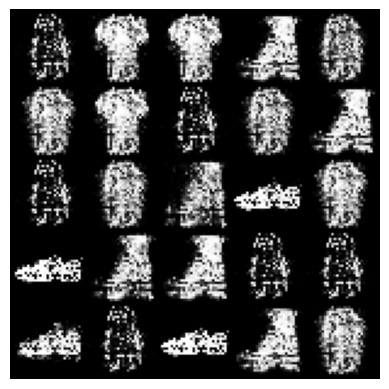

Epoch: 1900/2000 | G Loss: 0.70447 | D Loss: 1.3851
Epoch: 1910/2000 | G Loss: 0.69198 | D Loss: 1.3858
Epoch: 1920/2000 | G Loss: 0.6894 | D Loss: 1.3836
Epoch: 1930/2000 | G Loss: 0.69997 | D Loss: 1.3887
Epoch: 1940/2000 | G Loss: 0.6917 | D Loss: 1.3859
Epoch: 1950/2000 | G Loss: 0.6924 | D Loss: 1.3863
Epoch: 1960/2000 | G Loss: 0.68353 | D Loss: 1.3767
Epoch: 1970/2000 | G Loss: 0.70067 | D Loss: 1.3822
Epoch: 1980/2000 | G Loss: 0.69939 | D Loss: 1.3828
Epoch: 1990/2000 | G Loss: 0.69184 | D Loss: 1.3859


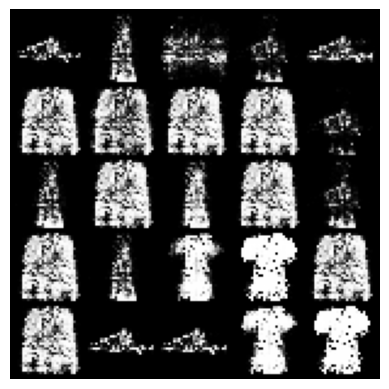

Epoch: 2000/2000 | G Loss: 0.71141 | D Loss: 1.3793


In [8]:
epochs = 2000
lr = 0.00001
noise_dim = 64

gen = Generator(indim=noise_dim).to(device)
disc = Discriminator().to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

criterion = torch.nn.BCEWithLogitsLoss()

for i in range(epochs):
    losses = {
        'disc': 0,
        'gen': 0
    }
    c = 0
    for x, _ in train_loader:
        real = x.view(-1, 28*28).to(device)
        noise = random_noise(batch_size, dim=noise_dim, device=device)

                
        # Generator
        gen_opt.zero_grad()
        gen_loss, fake = gen_loss_fn(gen, disc, noise, criterion)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        
        
        # Discriminator
        disc_opt.zero_grad()
        disc_loss = disc_loss_fn(disc, real, fake, criterion)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        
        losses['disc'] += disc_loss.item()
        losses['gen'] += gen_loss.item()
        c += 1
    
    if (i+1) % 100 == 0:
        preds = gen(random_noise(25, dim=noise_dim, device=device))
        show_tensor_images(preds)
    
    if (i+1) % 10 == 0:
        print(f"Epoch: {i+1:4}/{epochs} | G Loss: {losses['gen']/c:.5} | D Loss: {losses['disc']/c:.5}")
    